In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-05a30703-b842-5a2b-9c11-02cc84a8a7e4"

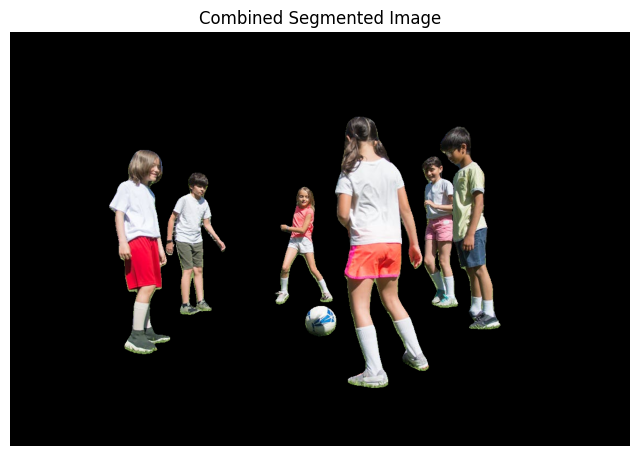

In [ ]:
from ultralytics import YOLO, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the YOLO model
yolo_model = YOLO("yolo11n.pt")  # Replace with your YOLO model path
# Load the SAM model
sam_model = SAM("sam2.1_b.pt")  # Replace with your SAM model path

# Load the image
image_path = "../images/football_teamplay.jpeg"  # Replace with your image path
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform object detection using YOLO
results = yolo_model(image_path, imgsz=640, verbose=False)

# Initialize a blank mask for combining all segments
combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

# Iterate through YOLO results
for result in results:
    # Extract bounding boxes and class IDs
    boxes = result.boxes.xyxy.cpu().numpy()  # (xmin, ymin, xmax, ymax)
    class_ids = result.boxes.cls.int().tolist()
    
    # Iterate through each detected object
    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = map(int, box)
        bbox = [xmin, ymin, xmax, ymax]
        
        # Perform segmentation using SAM with the detected bounding box
        sam_results = sam_model.predict(image_path, bboxes=[bbox], verbose=False)
        
        # Extract the segmentation mask
        if sam_results[0].masks is not None:
            mask = sam_results[0].masks.data[0].cpu().numpy().astype(np.uint8)
            
            # Resize the mask to the original image dimensions
            mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]))
            
            # Combine the mask with the existing masks
            combined_mask = cv2.bitwise_or(combined_mask, mask_resized)

# Apply the combined mask to the image using bitwise AND
segmented_image = cv2.bitwise_and(image_rgb, image_rgb, mask=combined_mask)

# Visualize the combined segmentation
plt.figure(figsize=(8, 8))
plt.imshow(segmented_image)
plt.title("Combined Segmented Image")
plt.axis("off")
plt.show()



image 1/1 /root/workspace/code/Github/DL-FOR-COMPUTER-VISION/week08/../images/football_teamplay.jpeg: 448x640 6 persons, 1 sports ball, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


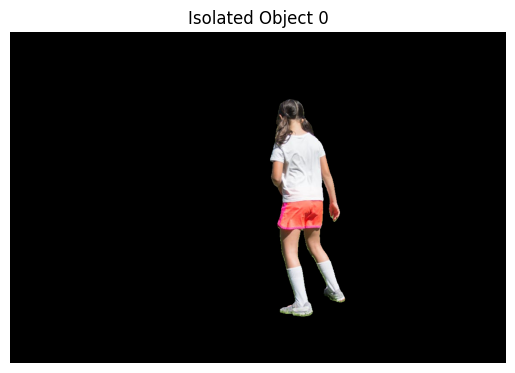

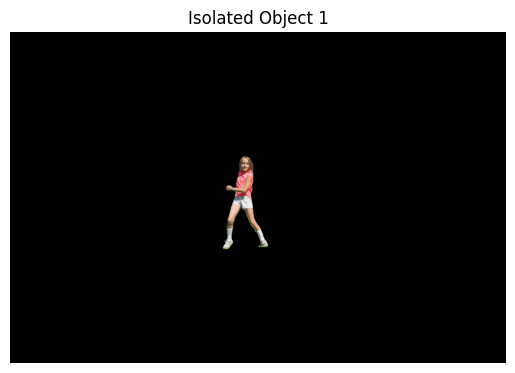

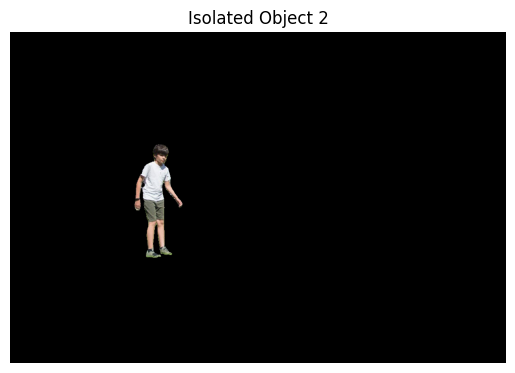

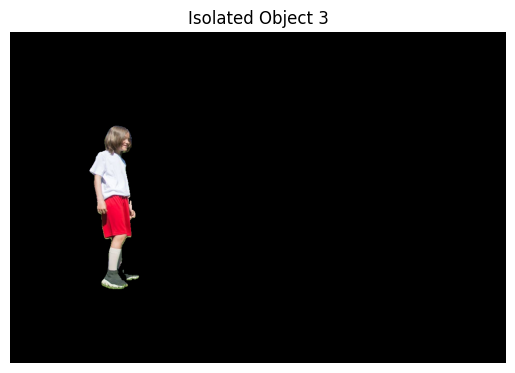

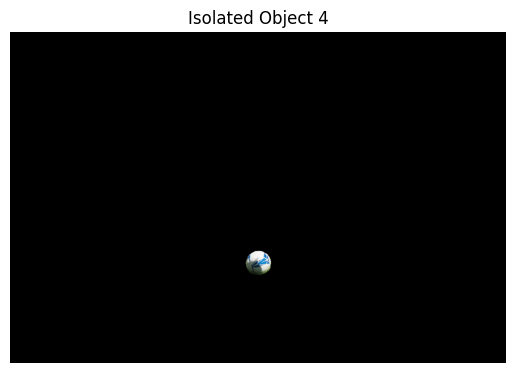

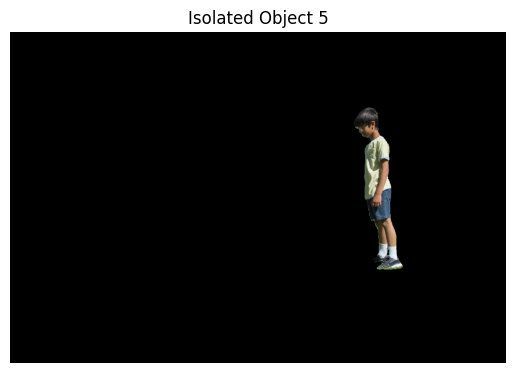

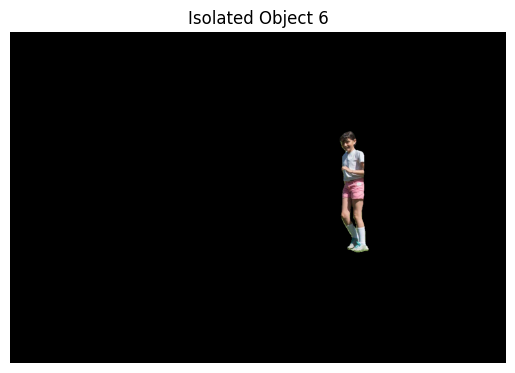

In [14]:
from ultralytics import YOLO, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt  # For visualization

# Load the YOLOv11 model
yolo_model = YOLO("yolo11n.pt")  # Replace with your model path if different

# Load the SAM model
sam_model = SAM("sam_b.pt")  # Replace with your model path if different

# Perform object detection
results = yolo_model("../images/football_teamplay.jpeg")  # Replace with your image path

for result in results:
    class_ids = result.boxes.cls.int().tolist()
    if class_ids:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes in (xmin, ymin, xmax, ymax) format

        # Generate segmentation masks
        sam_results = sam_model(result.orig_img, bboxes=boxes, verbose=False, device="cuda:0")

        # Use the first SAM result (sam_results[0])
        for i, (box, mask) in enumerate(zip(sam_results[0].boxes.xyxy, sam_results[0].masks.data)):
            # Convert the mask tensor to a NumPy array
            mask_np = mask.cpu().numpy().astype(np.uint8)


            # Prepare isolated object using bitwise_and
            orig_img_np = result.orig_img
            isolated_object = cv2.bitwise_and(orig_img_np, orig_img_np, mask=mask_np)

            # Convert isolated_object to RGB for plt.imshow
            isolated_object_rgb = cv2.cvtColor(isolated_object, cv2.COLOR_BGR2RGB)


            # Display the isolated object using plt.imshow
            plt.imshow(isolated_object_rgb)
            plt.axis("off")  # Turn off the axis for better visualization
            plt.title(f"Isolated Object {i}")  # Add a title for clarity
            plt.show()  # Display the image
